In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from abc import abstractmethod
import numpy as np
from fractalart.core import Image
from numba import njit, prange
import math
import matplotlib.pyplot as plt

In [3]:
class Fractal(Image):
    """Abstract base class for generating fractal images."""

    def __init__(
        self,
        width: int = 800,
        height: int = 800,
        x_min: float = -2.0,
        x_max: float = 1.0,
        y_min: float = -1.5,
        y_max: float = 1.5,
        max_iter: int = 1000,
    ):
        """Initialize the fractal with image resolution and complex plane bounds."""
        super().__init__(width, height)
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self.max_iter = max_iter  # Uses property setter for validation

    @abstractmethod
    def compute(self) -> np.ndarray:
        """Abstract method to compute the fractal array. Must be implemented by subclasses."""
        pass

    @property
    def max_iter(self) -> int:
        """Maximum number of iterations used in fractal computation."""
        return self._max_iter

    @max_iter.setter
    def max_iter(self, value: int):
        if value <= 0:
            raise ValueError("max_iter must be a positive integer.")
        self._max_iter = value

    def plot(self, cmap: str = "turbo"):
        """Display the rendered fractal image using matplotlib."""
        # TODO : Us lighter image plotting, e. g. using PIL.Image or cv2
        plt.figure(figsize=(8, 8))
        plt.imshow(
            self._image,
            cmap=cmap,
            extent=[self._x_min, self._x_max, self._y_min, self._y_max],
            origin='lower'
        )
        plt.axis('off')
        plt.show()
    
    def set_zoom(self, zoom: float, center: tuple[float, float]):
        """
        Zoom into the fractal at a specific center.

        Args:
            zoom: Zoom factor (higher is closer).
            center: (x, y) center coordinates in the complex plane.
        """
        if zoom <= 0:
            raise ValueError("zoom must be a positive number.")
        delta = 2 / zoom
        cx, cy = center
        self._x_min, self._x_max = cx - delta, cx + delta
        self._y_min, self._y_max = cy - delta, cy + delta

    def _render(self):
        """Generate and store the fractal image using the subclass-defined `compute` method."""
        self._image = self.compute()

In [4]:
@njit(parallel=True, fastmath=True)
def _compute_mandelbrot_set(x_min: float, x_max: float, y_min: float, y_max: float, width: int, height: int, max_iter: int) -> np.ndarray:
    # Allocate with float32 to halve memory bandwidth (optional)
    result = np.zeros((height, width), dtype=np.float32)
    cross_trap = np.zeros((height, width), dtype=np.float32)

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)

    inv_log2 = 1.0 / math.log(2.0)   # for nu calculation
    log2_const = math.log(2.0)

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = 0.0
            zi = 0.0
            cr = zx
            ci = zy
            iteration = 0
            min_cross = 1e10

            # Mandelbrot iteration
            while iteration < max_iter:
                # TODO : use zr * zr + zi * zi <= 4 and iteration < max_iter for classical fractal calculation without orbit traps
                # (zr + i zi)^2 + c
                zr2 = zr * zr - zi * zi + cr
                zi = 2.0 * zr * zi + ci
                zr = zr2
                iteration += 1

                # Cross trap: distance to real or imaginary axis
                # TOTO : only take the min after a specific number of iterations , e. g. iteration > 3:
                if iteration > 2:
                    cross_dist = min(abs(zr), abs(zi))
                    if (cross_dist < min_cross):
                        min_cross = cross_dist

            if iteration < max_iter:
                # smooth coloring
                mag_sq = zr * zr + zi * zi
                log_zn = 0.5 * math.log(mag_sq)
                nu = math.log(log_zn * inv_log2) * inv_log2
                result[j, i] = iteration + 1 - nu
            else:
                result[j, i] = iteration

            cross_trap[j, i] = min_cross

    #return result
    return cross_trap


class Mandelbrot(Fractal):
    def compute(self) -> np.ndarray:
        w, h = self.resolution
        # pass resolution-consistent dims
        return _compute_mandelbrot_set(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._max_iter)

In [5]:
#| export
@njit(parallel=True, fastmath=True)
def _compute_julia_set(xmin, xmax, ymin, ymax, width, height, cr, ci, max_iter):
    dx = (xmax - xmin) / (width - 1)
    dy = (ymax - ymin) / (height - 1)
    result = np.zeros((height, width), dtype=np.float32)

    for j in prange(height):
        y0 = ymin + j * dy
        for i in range(width):
            x0 = xmin + i * dx
            x = x0
            y = y0
            iteration = 0
            while x*x + y*y <= 4.0 and iteration < max_iter:
                x_temp = x*x - y*y + cr
                y = 2.0 * x * y + ci
                x = x_temp
                iteration += 1

            if iteration < max_iter:
                # Smooth coloring
                modulus_sq = x*x + y*y
                log_zn = np.log(modulus_sq) / 2
                nu = np.log(log_zn / np.log(2)) / np.log(2)
                result[j, i] = iteration + 1 - nu
            else:
                result[j, i] = max_iter

    return result

class Julia(Fractal):
    def __init__(
        self,
        cr: float,
        ci: float,
        width: int   = 800,
        height: int  = 800,
        x_min: float = -1.5,   # override Fractal default
        x_max: float =  1.5,   # override Fractal default
        y_min: float = -1.5,   # keep same (or change)
        y_max: float =  1.5,   # keep same (or change)
        max_iter: int = 1000,  # keep same (or change)
    ):
        # 1) initialize the Fractal portion:
        super().__init__(width, height, x_min, x_max, y_min, y_max, max_iter)

        # 2) store Julia‐specific constants
        self._cr = cr
        self._ci = ci
        
    def compute(self) -> np.ndarray:
        w, h = self.resolution
        # pass resolution-consistent dims
        return _compute_julia_set(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._cr, self._ci, self._max_iter)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


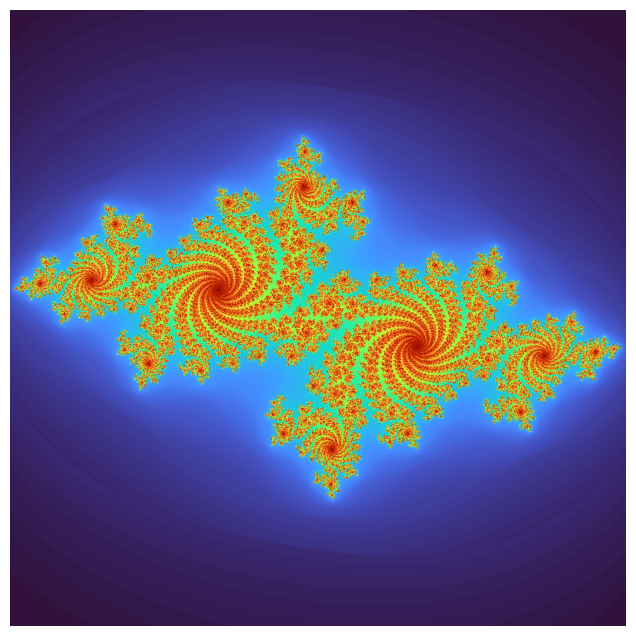

In [6]:
j = Julia(cr = -0.7, ci = 0.27015)
j.resolution = 1200, 1200
j.max_iter = 3000
j.render()
j.equalize_histogram()
j.plot()

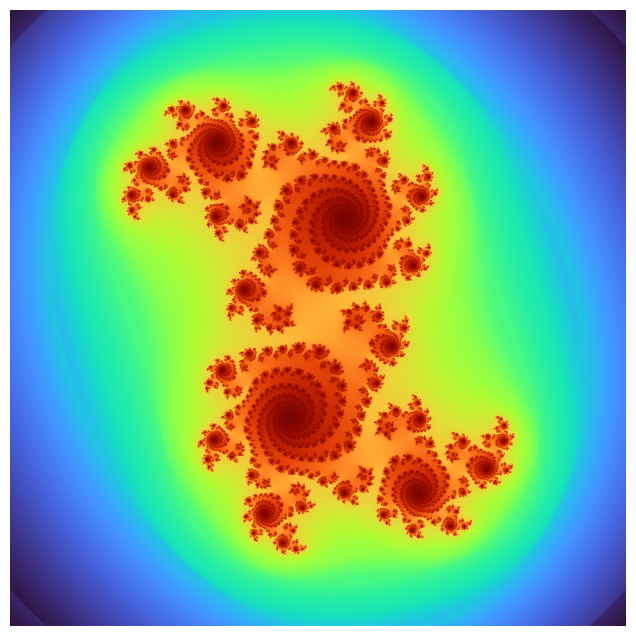

In [7]:
j = Julia(cr = 0.355, ci = 0.355)
j.resolution = 1200, 1200
j.max_iter = 3000
j.render()
j.equalize_histogram()
j.plot()

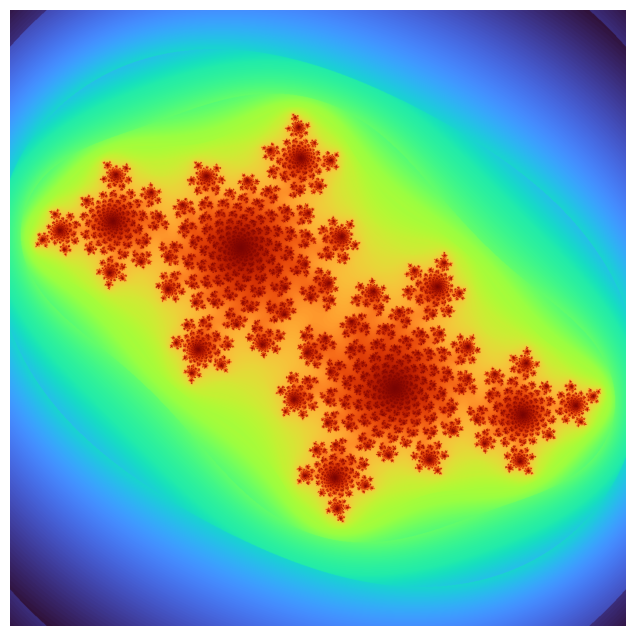

In [8]:
j = Julia(cr = -0.4, ci = 0.6)
j.resolution = 1200, 1200
j.max_iter = 3000
j.render()
j.equalize_histogram()
j.plot()

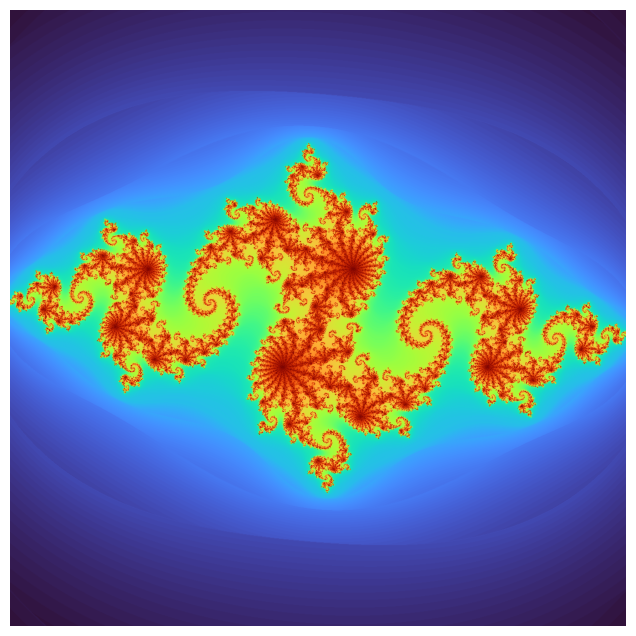

In [9]:
j = Julia(cr = -0.8, ci = 0.156)
j.resolution = 1200, 1200
j.max_iter = 3000
j.render()
j.equalize_histogram()
j.plot()

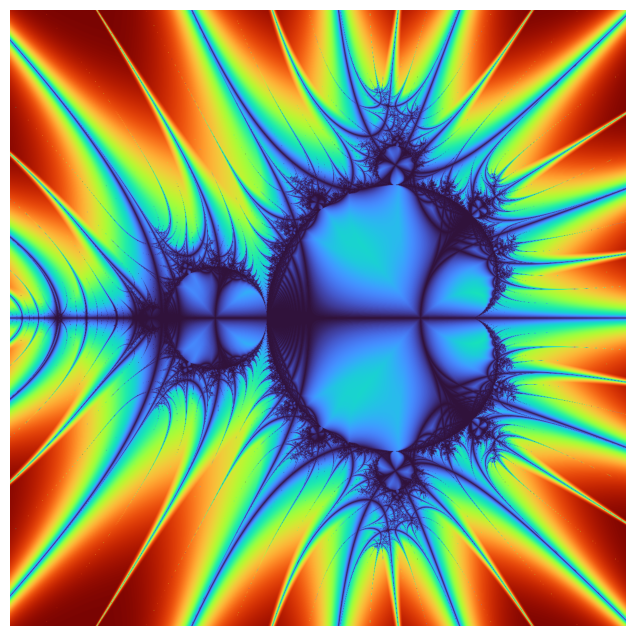

In [10]:
m = Mandelbrot()
m.resolution = 1200, 1200
m.max_iter = 3000
m.render()
m.equalize_histogram()
m.plot()

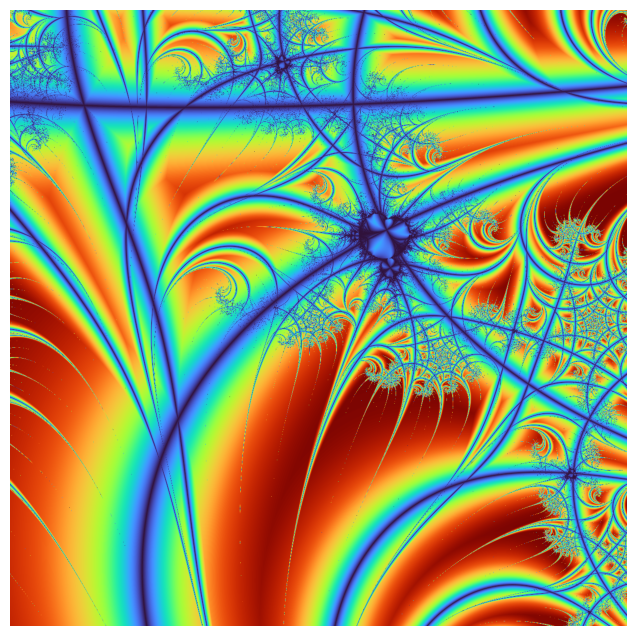

In [11]:
m = Mandelbrot()
m.resolution = 1200, 1200
m.max_iter = 3000

#m.set_zoom(5, (-0.170337,-1.06506))
#m.set_zoom(25, (-0.170337,-1.06506))
#m.set_zoom(125, (-0.170337,-1.06506))
#m.set_zoom(625, (-0.170337,-1.06506))
#m.set_zoom(3125, (-0.170337,-1.06506))
#m.set_zoom(15625, (-0.170337,-1.06506))
#m.set_zoom(78125, (-0.170337,-1.06506))

#m.set_zoom(5, (0.42884,-0.231345))
#m.set_zoom(25, (0.42884,-0.231345))
m.set_zoom(125, (0.42884,-0.231345))
#m.set_zoom(625, (0.42884,-0.231345))
#m.set_zoom(3125, (0.42884,-0.231345))
#m.set_zoom(15625, (0.42884,-0.231345))
#m.set_zoom(78125, (0.42884,-0.231345))

#m.set_zoom(5, (-1.62917,-0.0203968))
#m.set_zoom(25, (-1.62917,-0.0203968))
#m.set_zoom(125, (-1.62917,-0.0203968))
#m.set_zoom(625, (-1.62917,-0.0203968))
#m.set_zoom(3125, (-1.62917,-0.0203968))
#m.set_zoom(15625, (-1.62917,-0.0203968))
#m.set_zoom(78125, (-1.62917,-0.0203968))

#m.set_zoom(5, (-0.761574,-0.0847596))
#m.set_zoom(25, (-0.761574,-0.0847596))
#m.set_zoom(125, (-0.761574,-0.0847596))
#m.set_zoom(625, (-0.761574,-0.0847596))
#m.set_zoom(3125, (-0.761574,-0.0847596))
#m.set_zoom(15625, (-0.761574,-0.0847596))
#m.set_zoom(78125, (-0.761574,-0.0847596))

m.render()
m.equalize_histogram()
m.plot()

Using 10 ordered random colors


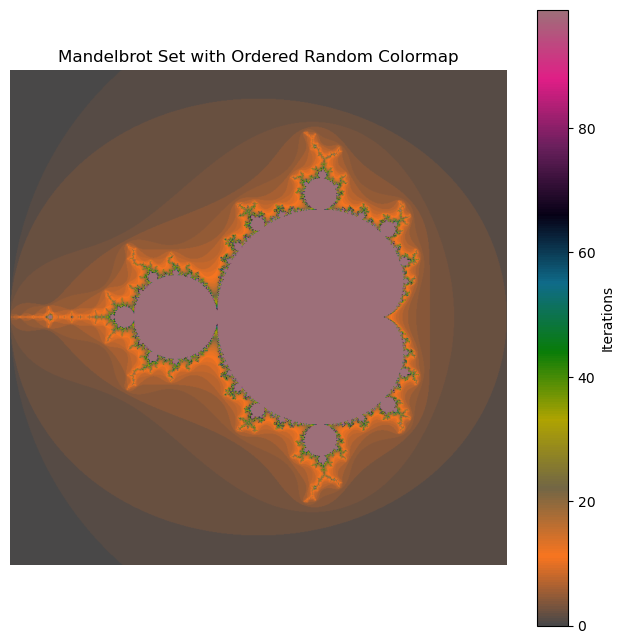

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import random
import colorsys

# Parameters for random color generation
min_colors = 10
max_colors = 10

def generate_ordered_random_colors(min_c, max_c):
    n_colors = random.randint(min_c, max_c)
    print(f"Using {n_colors} ordered random colors")

    # Generate random RGB and convert to HSL
    random_rgbs = [(random.random(), random.random(), random.random()) for _ in range(n_colors)]
    random_hsl = [colorsys.rgb_to_hls(*rgb) for rgb in random_rgbs]

    # Sort by hue (H in HSL)
    sorted_hsl = sorted(random_hsl, key=lambda hsl: hsl[0])

    # Convert back to RGB
    sorted_rgb = [colorsys.hls_to_rgb(*hsl) for hsl in sorted_hsl]
    return sorted_rgb

# Create an ordered random colormap
ordered_colors = generate_ordered_random_colors(min_colors, max_colors)
ordered_cmap = LinearSegmentedColormap.from_list("ordered_cmap", ordered_colors, N=256)

# Mandelbrot function
def mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter):
    x = np.linspace(xmin, xmax, width)
    y = np.linspace(ymin, ymax, height)
    C = x[:, np.newaxis] + 1j * y[np.newaxis, :]
    Z = np.zeros_like(C)
    output = np.zeros(C.shape, dtype=int)

    for i in range(max_iter):
        mask = np.abs(Z) < 2
        Z[mask] = Z[mask]**2 + C[mask]
        output[mask] = i
    return output

# Generate fractal data
data = mandelbrot(-2, 1, -1.5, 1.5, 800, 800, 100)

# Plot the fractal with the ordered colormap
plt.figure(figsize=(8, 8))
im = plt.imshow(data.T, cmap=ordered_cmap, extent=(-2, 1, -1.5, 1.5), origin='lower')
plt.colorbar(im, label="Iterations")
plt.title("Mandelbrot Set with Ordered Random Colormap")
plt.axis('off')
plt.show()
